**연세대학교 데이터사이언스랩 A조**  
3기 유승용   
4기 김새민   
4기 김선우  
4기 위효원  
4기 호은재  

## 목차 

1. 분석의 개요
2. 데이터 시각화
3. 지역별 정책효과 분석
4. 실제 지역 추천

## 1. 분석의 개요

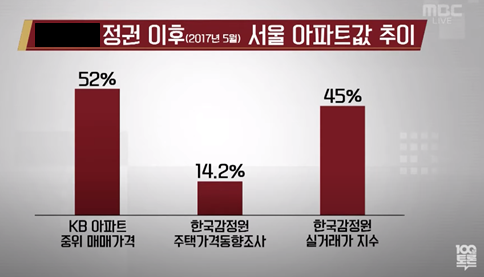

2020년 8월 기준 현재 서울의 아파트 가격은 계속해서 상승세에 놓여있다. 외국의 자본까지 서울 부동산 투자에 몰리는 가운데 청년들의 내집마련은 점점 어려워지고있다. 사회 전체적으로 부동산 이슈들이 큰 관심을 받고있는 가운데 전반적인 서울의 부동산 흐름과 투자 전략을 대략적이나마 파악해야 추후 집을 마련하거나 부동산을 투자하는데 있어서 큰 도움이 될 것으로 예상되어, A조는 부동산 투자 관련 프로젝트를 진행하고자 결정했다.   
우리의 데이터는 **국토교통부가 발표한 서울지역 아파트 실거래가 데이터**로, 2016년 1월부터 2020년 7월 말까지의 거래내역을 담고있다. 

#### 아파트란?? 

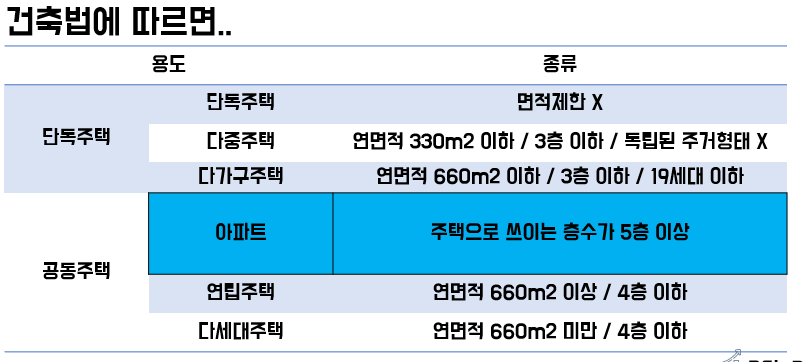

In [1]:
## 필요 패키지 로드

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import datetime
pd.options.display.max_rows = 20
import re
import math

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import warnings
warnings.filterwarnings(action='ignore')

## 아래는 matplotlib 한국어 표시해주는 코드

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import folium
import json
import urllib

In [2]:
import requests
from bs4 import BeautifulSoup as bs
from datetime import datetime

import sys 

def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100): 
    formatStr = "{0:." + str(decimals) + "f}" 
    percent = formatStr.format(100 * (iteration / float(total))) 
    filledLength = int(round(barLength * iteration / float(total))) 
    bar = '#' * filledLength + '-' * (barLength - filledLength) 
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix)), 
    if iteration == total: 
        sys.stdout.write('\n') 
        sys.stdout.flush() 

for i in range(0, 100): 
    printProgress(i, 100, 'Progress:', 'Complete', 1, 50)

Progress: |##################################################| 99.0% Complete

국토교통부는 1년치 데이터씩 제공을 한다. 따라서 데이터를 병합하고, 분석을 용이하게 하기 위해 '구'만 따로 떼어주고, 추후 분석을 용이하게 하기 위해 동도 구분한다.  
또한 가격이 ,가 들어간 str 값이기 때문에 Numeric으로 바꾸어준다

In [6]:
## 데이터 전처리 코드

os.chdir('C:\\Users\\82104\\Desktop\\새민이\\DSL\\프로젝트1_A조\\Project_1_Code')

apt_2016 = pd.read_csv('2016_apt.csv' ,encoding = 'CP949', header = 15)
apt_2017 = pd.read_csv('2017_apt.csv',encoding = 'CP949', header = 15)
apt_2018 = pd.read_csv('2018_apt.csv',encoding = 'CP949', header = 15)
apt_2019 = pd.read_csv('2019_apt.csv',encoding = 'CP949', header = 15)
apt_2020 = pd.read_csv('2020_apt.csv',encoding = 'CP949', header = 15)

apt_ = pd.concat([apt_2016, apt_2017, apt_2018, apt_2019, apt_2020])

price_ = []
for i in range(apt_.shape[0]) : 
    price_.append(int(apt_.iloc[i, 8].replace(',', '')))
    
new_price = pd.DataFrame(data = price_, columns = ['price_'])

apt_ = apt_.reset_index()
apt = pd.concat([apt_ , new_price], axis = 1).iloc[:,1:]
apt.drop(['거래금액(만원)'], axis = 1,inplace = True)

col_ = ['sigungu', 'bunzi', 'bonbun', 'bubun', 'name', 'house_size', 'year_month', 'date', 'floor', 'built_date', 'road_address', 'price']
apt.columns = col_

apt['only_gu'] = apt['sigungu'].map(lambda x : x.split()[1])
apt['dong'] = apt['sigungu'].map(lambda x : x.split()[2])
new_d = pd.DataFrame({'pyungdang' : apt.price / apt.house_size}, columns = ['pyungdang'])
seoul = pd.concat([apt, new_d], axis = 1)

최종 데이터셋은 현재 **seoul**에 할당된 상태다.

## 2. 데이터 시각화

### 2.1) 기초데이터

서울시 전체의 아파트 가격 추이를 확인해보도록 하겠습니다.  
큰 평수의 아파트와 작은 평수의 아파트의 가격차이를 보정해주기 위하여 저희는 거래 가격을 사용하지 않고 집 크기로 거래가격을 나눈 **'m2당 가격'**을 가격 지표로 사용하였습니다.

In [7]:
seoul = pd.concat([apt, new_d], axis = 1)
print(seoul.isnull().sum())

sigungu           0
bunzi           183
bonbun            0
bubun             0
name              0
house_size        0
year_month        0
date              0
floor             0
built_date        0
road_address      0
price             0
only_gu           0
dong              0
pyungdang         0
dtype: int64


In [8]:
print(set(seoul[seoul.bunzi.isnull() == True].sigungu))
seoul[seoul.bunzi.isnull() == True]

{'서울특별시 서초구 내곡동', '서울특별시 강남구 자곡동'}


,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang
6269,서울특별시 강남구 자곡동,NaN,0,0,래미안포레,84.99,201601,21,6,2014,밤고개로21길 25,78800,강남구,자곡동,927.167902
6270,서울특별시 강남구 자곡동,NaN,0,0,래미안포레,84.99,201603,21,6,2014,밤고개로21길 25,78600,강남구,자곡동,924.814684
6271,서울특별시 강남구 자곡동,NaN,0,0,래미안포레,84.99,201604,13,11,2014,밤고개로21길 25,78550,강남구,자곡동,924.226380
6272,서울특별시 강남구 자곡동,NaN,0,0,래미안포레,84.99,201604,16,3,2014,밤고개로21길 25,73000,강남구,자곡동,858.924579
6273,서울특별시 강남구 자곡동,NaN,0,0,래미안포레,84.99,201605,11,2,2014,밤고개로21길 25,80000,강남구,자곡동,941.287210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373292,서울특별시 강남구 자곡동,NaN,0,0,래미안포레,84.99,202006,7,1,2014,밤고개로21길 25,131700,강남구,자곡동,1549.594070
402183,서울특별시 서초구 내곡동,NaN,0,0,서초포레스타2단지,59.21,202002,8,13,2015,헌릉로8길 45,105000,서초구,내곡동,1773.349096
402184,서울특별시 서초구 내곡동,NaN,0,0,서초포레스타2단지,84.48,202003,7,20,2015,헌릉로8길 45,126500,서초구,내곡동,1497.395833
402185,서울특별시 서초구 내곡동,NaN,0,0,서초포레스타2단지,84.48,202007,5,14,2015,헌릉로8길 45,134000,서초구,내곡동,1586.174242


자곡동 래미안포레와 내곡동 포레스타의 번지가 결측치로 확인되었기 때문에 이를 채워주도록 하겠습니다.  
자곡동 번지수 = 361번지  
내곡동 번지수 = 143번지  

In [9]:
seoul = seoul.fillna('361')
seoul.loc[seoul['name'] == '서초포레스타2단지', 'bunzi'] = '143'

In [10]:
seoul.describe()

,bonbun,bubun,house_size,year_month,date,floor,built_date,price,pyungdang
count,420067.000000,420067.000000,420067.000000,420067.000000,420067.000000,420067.000000,420067.000000,420067.000000,420067.000000
mean,569.451668,5.561644,78.855089,201769.854052,15.889946,9.067263,1999.504669,65756.701443,832.041617
std,519.125423,42.047663,29.995779,134.198593,8.742879,6.122694,9.562247,46965.885204,437.766356
min,0.000000,0.000000,10.020000,201601.000000,1.000000,-3.000000,1961.000000,1100.000000,15.969803
25%,189.000000,0.000000,59.760000,201611.000000,8.000000,4.000000,1993.000000,37500.000000,539.802502
50%,476.000000,0.000000,84.220000,201712.000000,16.000000,8.000000,2000.000000,53000.000000,706.297822
75%,787.000000,1.000000,84.970000,201906.000000,23.000000,13.000000,2006.000000,78000.000000,986.357438
max,6040.000000,2837.000000,424.320000,202007.000000,31.000000,69.000000,2020.000000,840000.000000,6969.612490


서울시 아파트 전체 평균 가격의 **시계열 추이**를 확인해보겠습니다.

Text(0.5, 1.0, '서울시 전역 아파트 거래가 시계열 추이')

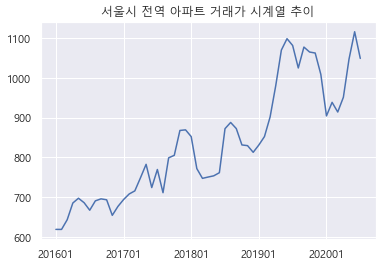

In [11]:
plt.plot(seoul.groupby(by = ['year_month'], as_index = False).mean().pyungdang)
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('서울시 전역 아파트 거래가 시계열 추이')

서울시 전역의 아파트추이는 국지적 등락을 반복하며 증가하고 있는 것을 확인할 수 있다.

Text(0, 0.5, '아파트 거래량')

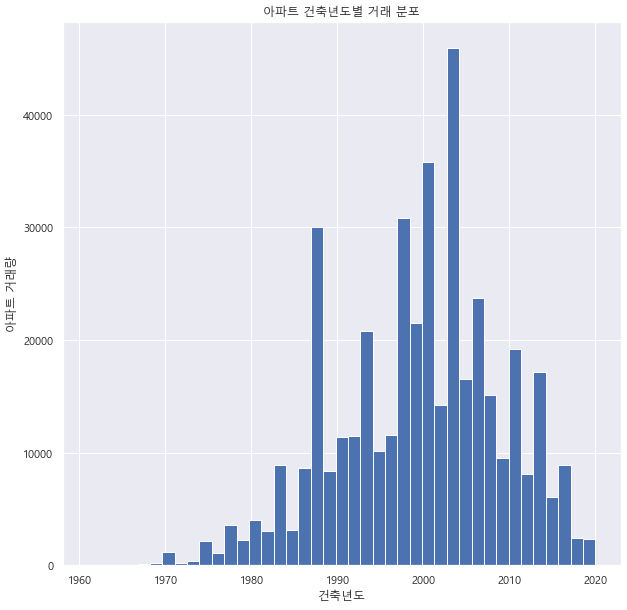

In [12]:
arranged = list(np.round(apt.built_date))
plt.figure(figsize = (10,10))
plt.title('아파트 건축년도별 거래 분포')
plt.hist(arranged, bins = 41)
plt.xlabel('건축년도')
plt.ylabel('아파트 거래량')

오래된 아파트일수록 거래가 오래되는 것이 아니라, 2000년대 초반에 지어진 아파트들이 더 많이 거래된 사실을 확인할 수 있습니다.

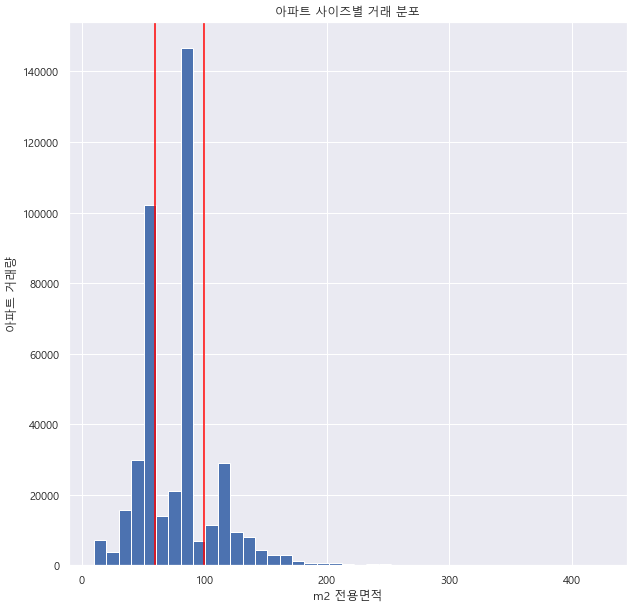

In [13]:
arranged = list(np.round(apt.house_size))
plt.figure(figsize = (10,10))
plt.title('아파트 사이즈별 거래 분포')
plt.hist(arranged, bins = 41)
plt.xlabel('m2 전용면적')
plt.ylabel('아파트 거래량')
plt.axvline(60, color = 'red')
plt.axvline(100, color = 'red')

건축법상 명확히 집의 크기에 따라 분류한 자료는 없습니다. 하지만 데이터 분포상 비율을 최대한 맞추기 위해, 우리는 60m2 이하의 집을 소형, 60m2 ~ 100m2을 중형, 100m2 이상을 대형으로 분류하기로 하였습니다.

### 2.2) 데이터 시각화

Json Source : http://www.gisdeveloper.co.kr/?p=2332  
***해당 소스에서 서울 시군구를 구분해주는 json을 다운받아 필요한 서울시만 편집하였습니다.***

In [14]:
geo_path = 'seoul_gu.json'
geo_str=json.load(open(geo_path, encoding='utf-8'))
seoul_ = seoul.groupby(by = ['dong'], as_index = False).mean()

구별 평균 가격 시각화

In [15]:
seoul_ = seoul.groupby(by = ['only_gu'], as_index = False).mean()
seoul_map = folium.Map(location = [37.5502, 126.982], zoom_start = 10.5, titles = 'cartodbpositron')
seoul_map.choropleth(geo_data = geo_str, 
                    data=seoul_, 
                    columns = ['only_gu', 'pyungdang'],
                    colorscale = 'Reds', 
                    key_on = 'properties.name', 
                    highlight = True,
                    fill_opacity = 0.5, line_oapacity = 1, 
                    legend_name = 'm2당 가격')
seoul_map

구별 아파트 개수 시각화

In [16]:
seoul_ = seoul['seoul_full_address'] = seoul['sigungu'] + seoul['bunzi']
seoul_ = pd.concat([seoul, seoul_], axis = 1)
seoul_ = seoul_.groupby(by = ['only_gu'], as_index = False).count()
seoul_map2 = folium.Map(location = [37.5502, 126.982], zoom_start = 10.5, titles = 'cartodbpositron')
seoul_map2.choropleth(geo_data = geo_str, 
                    data=seoul_, 
                    columns = ['only_gu', 'pyungdang'],
                    colorscale = 'Reds', 
                    key_on = 'properties.name', 
                    highlight = True,
                    fill_opacity = 0.5, line_oapacity = 1, 
                    legend_name = 'm2당 가격')
seoul_map2

가격의 경우 **강남구, 서초구**가 뚜렷하게 높고, 송파구, 용산구, 마포구가 그 뒤를 잇고있는 것을 확인할 수 있습니다.  
아파트 개수의 경우 **강서구와 노원구**가 비교적 많고, 강남구와 송파구 역시 개수가 꽤 많지만,   
가격이 높았던 **용산구의 경우 아파트 개수가 매우 적은것**을 확인할 수 있습니다.

지역별 아파트 분포

In [106]:
## KAKAO API로부터 각 주소에 대한 좌표를 불러온 후, folium에 찍어 시각화 하도록 하겠습니다.

def getGPS_coordinate_for_KAKAO(address, MYAPP_KEY):

    headers = {
        'Content-Type': 'application/json; charset=utf-8',
        'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)
    }
    address = address.encode("utf-8")

    p = urllib.parse.urlencode(
        {
            'query': address
        }
    )

    result = requests.get("https://dapi.kakao.com/v2/local/search/address.json", headers=headers, params=p)
    return result.json()

아래 코드에 API_CODE라고 적힌 부분에 각자의 API 코드를 넣고 돌리면 좌표를 얻을 수 있습니다. 

***카카오에서 일일 송신 API 횟수 제한이 걸려있기 때문에, 나눠서 하는 것을 권장드립니다. 결과물은 HTML로 첨부되어있습니다.***


In [153]:
seoul_ = seoul['seoul_full_address'] = seoul['sigungu'] + seoul['bunzi']
seoul_
xs = []
ys = []
for i,k in enumerate(sorted(set(seoul_))) : 
    if getGPS_coordinate_for_KAKAO(k, 'API_CODE')['documents'] == [] :
        x_ = 0
        y_ = 0
    else : 
        x_ = getGPS_coordinate_for_KAKAO(k, 'API_CODE')['documents'][0]['address']['x']
        y_ = getGPS_coordinate_for_KAKAO(k, 'API_CODE')['documents'][0]['address']['y']
    xs.append(float(x_))
    ys.append(float(y_))
    printProgress(i, 8304, 'Progress:', 'Complete', 1, 50)

Progress: |################################################--| 96.1% Complete

SSLError: HTTPSConnectionPool(host='dapi.kakao.com', port=443): Max retries exceeded with url: /v2/local/search/address.json?query=%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C+%EC%A4%91%EA%B5%AC+%EC%8B%A0%EB%8B%B9%EB%8F%99851 (Caused by SSLError(SSLError("bad handshake: SysCallError(10060, 'WSAETIMEDOUT')")))

In [ ]:
seoul_cord_x = xs
seoul_cord_y = ys

def color_producer(value) : 
    if value >= 805 : 
        col = 'darkred'
    elif value >= 591 and value < 805 : 
        col = 'red' 
    elif value >= 448 and value < 591 : 
        col = 'orange'
    else : 
        col = 'yellow'
        
    return col
        
tt = pd.concat([seoul.groupby(by = ['sigungu', 'bunzi', 'name'], as_index = False).mean(), 
               pd.DataFrame({'x':seoul_cord_x, 'y' : seoul_cord_y}, columns = ['x', 'y'])], axis = 1)
tt = tt.fillna(0)

tt_0 = tt[tt.pyungdang < 448]
tt_75 = tt[tt.pyungdang >= 805]
tt_50_1 = tt[tt.pyungdang < 805]
tt_50 = tt_50_1[tt_50_1.pyungdang>=591]
tt_25_1 = tt[tt.pyungdang < 591]
tt_25 = tt_25_1[tt_25_1.pyungdang >= 448]

center = [37.541, 126.986] 
m = folium.Map(location=center, 
               tiles='cartodbpositron',
               zoom_start=10)

colors = ['darkred', 'red', 'orange', 'yellow']
names = ['1st q', '2nd q', '3rd q', '4th q']

for i, data in enumerate([tt_75, tt_50, tt_25, tt_0]) :
    color = colors[i]
    name = names[i]
    fg = folium.FeatureGroup(name = name, col = color)
    for j in data.index : 
        folium.Circle(location = data.loc[j, ['x', 'y']].values, 
                        tooltip = data.loc[j, ['pyungdang', 'name']].values,
                         color = color, 
                         radius = 5).add_to(fg)
    m.add_child(fg)

folium.map.LayerControl('topright', collapes = False).add_to(m)
m

## 3. 정책효과 분석

정부는 집값을 잡기 위해 다양한 대책을 내놓았다. 

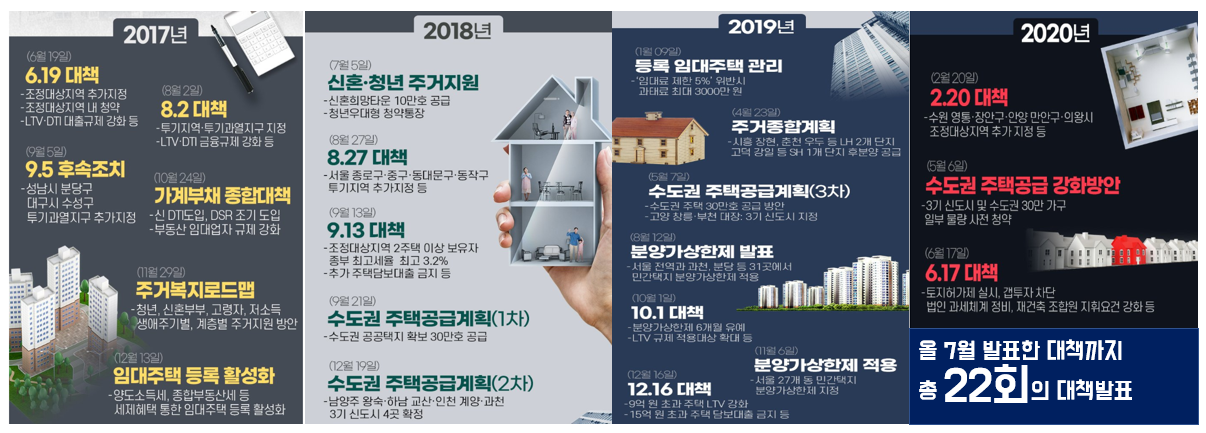

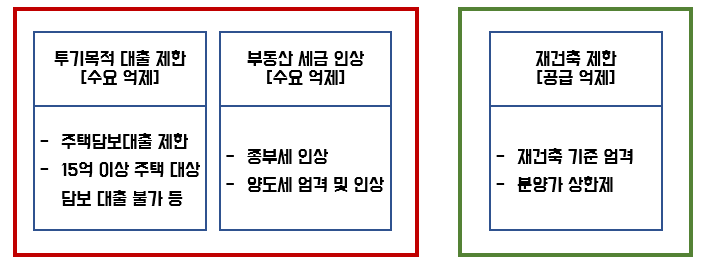

다음의 수요 억제 정책과 공급 억제는 분명 다른 영향을 다른 대상에게 미칠 것이다.   
공급 억제의 경우 재건축 대상 아파트들에 강한 타격이 올 것이다. 우리나라는 재건축 연한이 30년이므로, 프리미엄이 1~2년 전부터 적용되는 것을 감안하여 **1988년 이전의 아파트를 하나의 그룹**으로, 그리고 프리미엄이 사실상 없는 **2000년 이후에 준공된 아파트를 하나의 그룹**으로 하여 둘을 분할하여 분석했다.

두번째로, 전체 지역구를 동등하게 놓고 보는것은 의미가 없다고 판단하여, 우리는 부동산 업계의 일반적인 분류 기준인 강남3구, 마용성에 따라 현재 부동산 분야의 핫토픽인 이 둘을 파악하는데 주안점을 두고, **강남3구(강남구 서초구 잠실(잠실동, 신천동))**, **마용성송(마포구, 용산구, 성동구, 잠실 외 송파구)**을 분석했다.

### 3.1) 서울시 전역

Plot을 그릴 함수를 정의하겠습니다.

In [21]:
def timewise_plot (dataset, title) : 
    old = dataset[dataset.built_date <= 1988]
    new = dataset[dataset.built_date > 2000]
    old = old.groupby(by = ['year_month'], as_index = False).mean().pyungdang
    new = new.groupby(by = ['year_month'], as_index = False).mean().pyungdang
    plt.plot(np.arange(55), old, color = 'red', label = '재건축 프리미엄')
    plt.plot(np.arange(55), new, color = 'blue', label = '프리미엄 X')
    plt.axvline([20], color = 'black')
    plt.axvline([44], color = 'black')
    plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
    plt.legend()
    plt.title(title)
    plt.show()
    
def simple_plot(dataset, title) : 
    dataset = dataset.groupby(by = ['year_month'], as_index = False).mean().pyungdang
    plt.plot(np.arange(55), dataset, label = 'm2당 가격')
    plt.axvline([20], color = 'black')
    plt.axvline([33], color = 'black')
    plt.axvline([45], color = 'black')
    plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
    plt.legend()
    plt.title(title)
    plt.show()
    
def sizewise_plot(dataset, title) :
    small = dataset[dataset.house_size <= 60]
    middle_p = dataset[dataset.house_size < 100]
    middle = middle_p[middle_p.house_size > 60]
    big = dataset[dataset.house_size >= 100]
    small = small.groupby(by = ['year_month'], as_index = False).mean().pyungdang
    middle = middle.groupby(by = ['year_month'], as_index = False).mean().pyungdang
    big = big.groupby(by = ['year_month'], as_index = False).mean().pyungdang
    plt.plot(np.arange(55), small, color = 'red', label = '소형')
    plt.plot(np.arange(55), middle, color = 'blue', label = '중형')
    plt.plot(np.arange(55), big, color = 'green', label = '대형')
    plt.axvline([20], color = 'black')
    plt.axvline([33], color = 'black')
    plt.axvline([45], color = 'black')
    plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
    plt.legend()
    plt.title(title)
    plt.show()
    
def sizewise_amount_plot(dataset, title) :
    small = dataset[dataset.house_size <= 60]
    middle_p = dataset[dataset.house_size < 100]
    middle = middle_p[middle_p.house_size > 60]
    big = dataset[dataset.house_size >= 100]
    small = small.groupby(by = ['year_month'], as_index = False).count().pyungdang
    middle = middle.groupby(by = ['year_month'], as_index = False).count().pyungdang
    big = big.groupby(by = ['year_month'], as_index = False).count().pyungdang
    plt.plot(np.arange(55), small, color = 'red', label = '소형')
    plt.plot(np.arange(55), middle, color = 'blue', label = '중형')
    plt.plot(np.arange(55), big, color = 'green', label = '대형')
    plt.axvline([20], color = 'black')
    plt.axvline([33], color = 'black')
    plt.axvline([45], color = 'black')
    plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
    plt.legend()
    plt.title(title)
    plt.show()

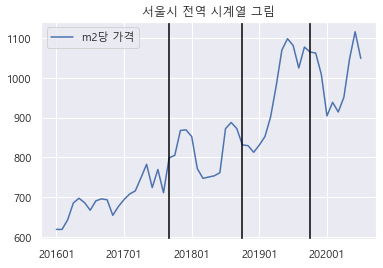

In [18]:
simple_plot(seoul, '서울시 전역 시계열 그림')

정책에 따른 전체적인 흐름을 보면, 정책에 따른 특정 가격변동이 일관되지 않는다. 좀 더 구체적으로 파악해보면 다음과 같다.

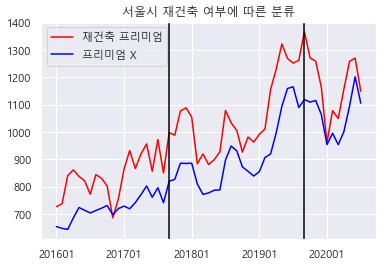

In [20]:
timewise_plot(seoul, '서울시 재건축 여부에 따른 분류')

재건축 프리미엄이 있는 아파트와 없는 아파트가 거의 동일한 추이를 보인다.   
#### 서울시의 재건축 정책은 데이터상으로는 특별한 효과를 주었다고 파악되지는 않는다.

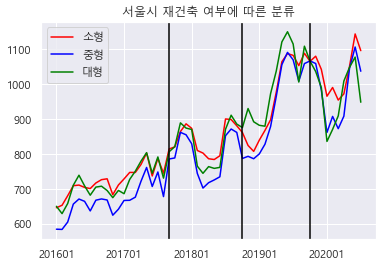

In [21]:
sizewise_plot(seoul, '서울시 재건축 여부에 따른 분류')

집 크기에 따른 세 분류의 구분이 뚜렷한 차이를 보이지 않는다.

### 3.2) 강남 3구 분석

In [24]:
seocho = seoul[seoul.only_gu == '서초구']
gangnam = seoul[seoul.only_gu == '강남구']
jamsil1 = seoul[seoul.dong == '잠실동']
jamsil2 = seoul[seoul.dong == '신천동']

gangnam_3 = pd.concat([gangnam, seocho, jamsil1, jamsil2], axis = 0)
gangnam_3.head(3)

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201603,28,5,1988,언주로 103,75000,강남구,개포동,964.630225,서울특별시 강남구 개포동655-2
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201604,2,2,1988,언주로 103,71000,강남구,개포동,913.183280,서울특별시 강남구 개포동655-2
2,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201605,6,9,1988,언주로 103,76900,강남구,개포동,989.067524,서울특별시 강남구 개포동655-2


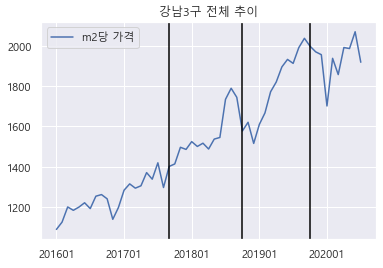

In [25]:
simple_plot(gangnam_3, '강남3구 전체 추이')

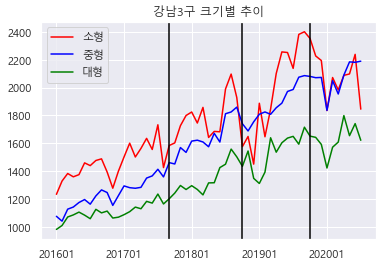

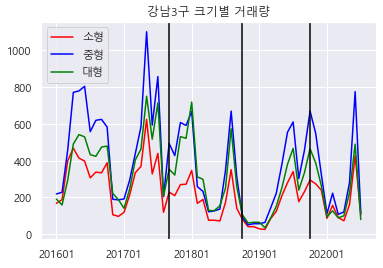

In [28]:
sizewise_plot(gangnam_3, '강남3구 크기별 추이')
sizewise_amount_plot(gangnam_3, '강남3구 크기별 거래량')

크기별 유의미한 차이가 있는 것으로 보이지만, 사실은 거래량 부족에 따른 데이터 불안전성 때문인 것으로 파악되었다. 특히 19년도 1월 전후로는 거래량이 20~30개에 머물면서 매월 다른 추이를 보여주었다. 따라서 크기별 구분 셋 간 유의미한 차이가 있다고 판단되지는 않는다.

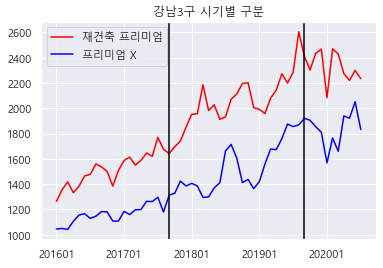

In [30]:
timewise_plot(gangnam_3, '강남3구 시기별 구분')

이러한 재건축에 대한 분석은 다음과 같다. 

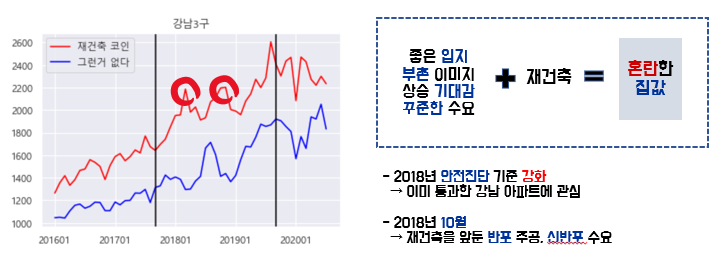

따라서 많은 정책이 강남을 타겟팅하여 나왔지만, 실효성이 명확이 있었다고 판단되지는 않는다.

### 3.3) 마용성송

마용성송 데이터셋 

In [27]:
songpa = seoul[seoul["only_gu"] == "송파구 "]
mapo = seoul[seoul["only_gu"] == "마포구 "]
yongsan = seoul[seoul["only_gu"] == "용산구 "]
seongdong = seoul[seoul["only_gu"] == "성동구 "]

In [28]:
songpa.dong.unique()

array(['가락동', '거여동', '마천동', '문정동', '방이동', '삼전동', '석촌동', '송파동', '신천동',
       '오금동', '잠실동', '장지동', '풍납동'], dtype=object)

In [29]:
songpa = songpa.reset_index()
temp=[]
for i in range(len(songpa.sigungu)):
    temp.append(songpa["sigungu"][i][-3:] not in ["잠실동", "신천동"])

xxjamsil = songpa[temp]

In [30]:
smy = pd.concat([xxjamsil, mapo, yongsan, seongdong])

마용성송 시각화

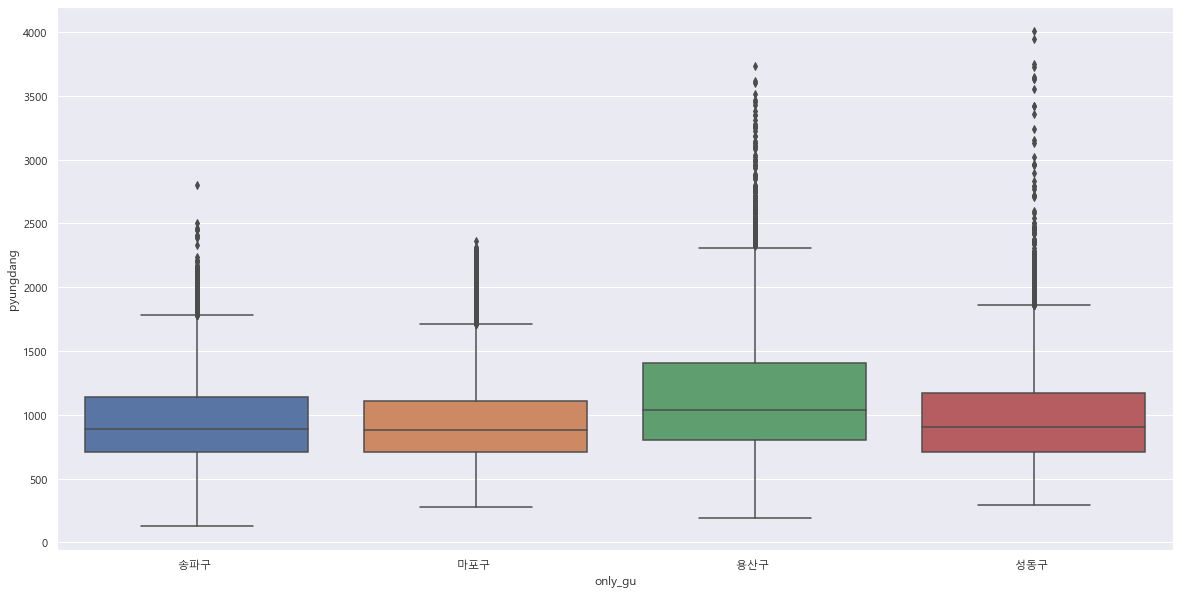

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot(x="only_gu", y="pyungdang", data=smy)
plt.show()

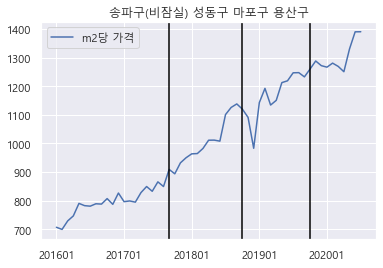

In [32]:
simple_plot(smy, "송파구(비잠실) 성동구 마포구 용산구")

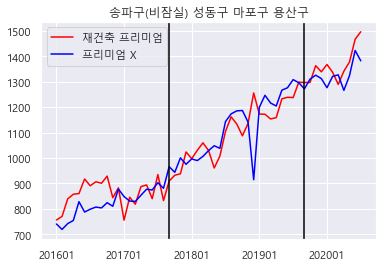

In [33]:
timewise_plot(smy, "송파구(비잠실) 성동구 마포구 용산구")

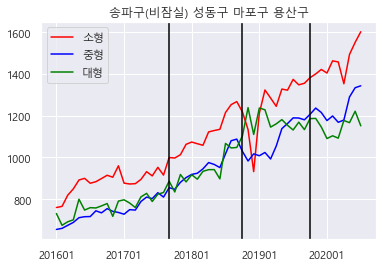

In [34]:
sizewise_plot(smy, "송파구(비잠실) 성동구 마포구 용산구")

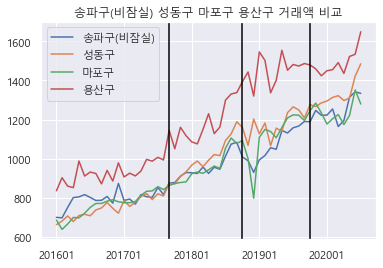

In [35]:
plt.plot(np.arange(55), xxjamsil.groupby(by = ['year_month'], as_index = False).mean().pyungdang, label = '송파구(비잠실)')
plt.plot(np.arange(55), seongdong.groupby(by = ['year_month'], as_index = False).mean().pyungdang, label = '성동구')
plt.plot(np.arange(55), mapo.groupby(by = ['year_month'], as_index = False).mean().pyungdang, label = '마포구')
plt.plot(np.arange(55), yongsan.groupby(by = ['year_month'], as_index = False).mean().pyungdang, label = '용산구')
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.legend()
plt.title("송파구(비잠실) 성동구 마포구 용산구 거래액 비교")
plt.show()

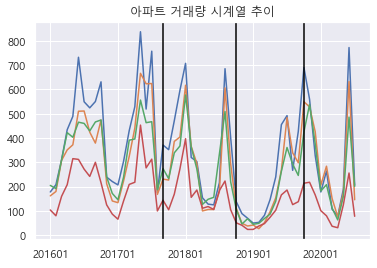

In [36]:
plt.plot(xxjamsil.groupby(by = ['year_month'], as_index = False).count().price)
plt.plot(seongdong.groupby(by = ['year_month'], as_index = False).count().price)
plt.plot(mapo.groupby(by = ['year_month'], as_index = False).count().price)
plt.plot(yongsan.groupby(by = ['year_month'], as_index = False).count().price)
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001]) 
plt.title('아파트 거래량 시계열 추이')
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')
plt.show()

마용성송 outlier 파악

In [37]:
smy[smy["year_month"]==201812].groupby('name').count().date.sum()

200

In [38]:
smy[smy["year_month"]==201812].groupby('name').count().date

name
2차한양아파트        1
가락(1차)쌍용아파트    2
강변힐스테이트        1
갤러리아 포레        2
건영월드컵          1
              ..
현대3차           1
현대리버빌1지구       2
현대주상복합         1
현대하이페리온II      1
혜당             1
Name: date, Length: 103, dtype: int64

In [39]:
smy[smy["year_month"]==201812][smy['built_date']==2018].groupby('name').count().pyungdang

name
마포자이3차(서울리츠2호 임대)    28
송파건원여미지아파트           33
Name: pyungdang, dtype: int64

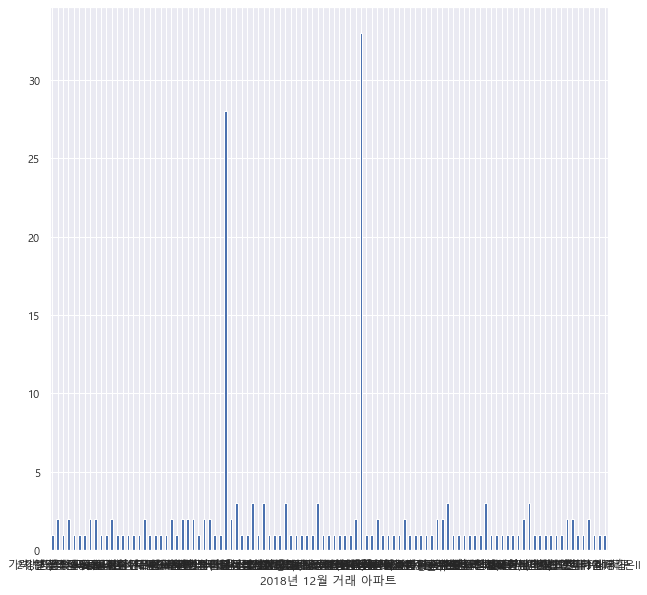

In [41]:
plt.figure(figsize=(10,10))
(smy[smy["year_month"]==201812].groupby('name').count().price).plot.bar(rot=0)
plt.xlabel("2018년 12월 거래 아파트")
plt.show()

outlier 제외 전체 추이

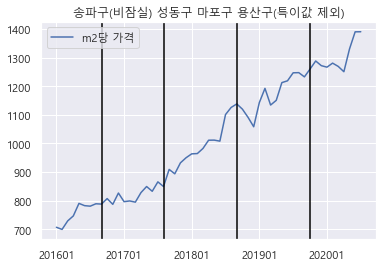

In [42]:
dataset = smy[smy['name']!=("마포자이3차(서울리츠2호 임대)" or smy['name']!="송파건원여미지아파트")]
dataset = dataset.groupby(by = ['year_month'], as_index = False).mean().pyungdang
plt.plot(np.arange(55), dataset, label = 'm2당 가격')
plt.axvline([8], color = 'black')
plt.axvline([19], color = 'black')
plt.axvline([32], color = 'black')
plt.axvline([45], color = 'black')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.legend()
plt.title("송파구(비잠실) 성동구 마포구 용산구(특이값 제외)")
plt.show()

## 4. 부동산 추천 

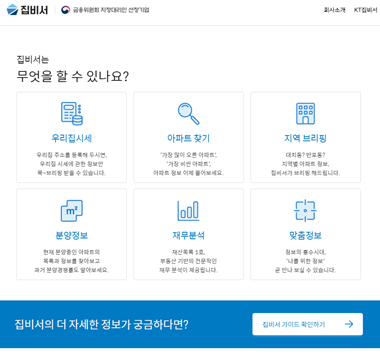

다음과 같이 부동산 분석의 수요는 시장에 충분히 존재한다. 우리는 실제로 있을법할 가능성이 높은 가상의 고객을 설정하여, 해당 고객에게 집을 추천하는 파트를 시행해 보았다.

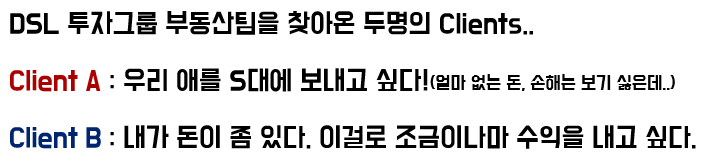

## 4.1) 교육의 메카 

“아이를 위해 좋은 교육 환경이 있는 곳으로 이사를 가고 싶은데, 

어디로 가는 게 좋을까요?

참고로, 돈이 엄청 많지는 않아서, 나중에 대학 들어간 후

다른 곳으로 이사할 때 손해는 없었으면 좋겠어요.”

서울 교육의 메카는 역시 대치와 목동이다. 그렇다면 이 둘을 순차적으로 알아보자.

### 대치

In [38]:
gangnam = seoul[seoul.only_gu == '강남구']
daechi = gangnam[gangnam.dong == '대치동']
daechi.head()

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
1506,서울특별시 강남구 대치동,503,503,0,개포우성1,84.81,201601,14,9,1983,선릉로 120,110000,강남구,대치동,1297.016861,서울특별시 강남구 대치동503
1507,서울특별시 강남구 대치동,503,503,0,개포우성1,127.61,201601,15,13,1983,선릉로 120,193200,강남구,대치동,1513.987932,서울특별시 강남구 대치동503
1508,서울특별시 강남구 대치동,503,503,0,개포우성1,127.61,201601,21,12,1983,선릉로 120,190000,강남구,대치동,1488.911527,서울특별시 강남구 대치동503
1509,서울특별시 강남구 대치동,503,503,0,개포우성1,127.61,201603,5,2,1983,선릉로 120,172500,강남구,대치동,1351.774939,서울특별시 강남구 대치동503
1510,서울특별시 강남구 대치동,503,503,0,개포우성1,127.61,201603,22,1,1983,선릉로 120,170000,강남구,대치동,1332.183998,서울특별시 강남구 대치동503


Text(0.5, 1.0, '대치 전역')

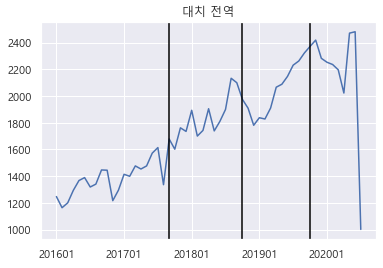

In [47]:
plt.plot(daechi.groupby(by = ['year_month'], as_index = False).mean().pyungdang)
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')
plt.title('대치 전역')

대치의 가장 유명한 아파트인 은마 아파트를 먼저 알아보자

Text(0.5, 1.0, '대치 은마')

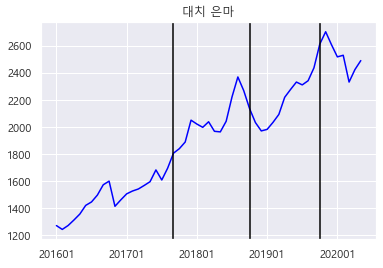

In [41]:
plt.plot(daechi[daechi.name == '은마'].groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])

plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')
plt.title('대치 은마')

통상 아파트에서 대단지로 분류하는 기준은 1000가구이다. 이러한 조건을 충족하는 대치동 아파트는 다음과 같은데, 이들과 은마를 비교해보도록 하자.

In [59]:
daechi_over1000 = ['개포우성1', '개포우성2', '선경2차(8동-12동)','은마','한보미도맨션1','한보미도맨션2','쌍용대치2',\
                   '쌍용대치아파트1동, 2동, 3동, 5동, 6동','래미안대치팰리스']
daechi_overall = seoul[seoul.name.map(lambda x: x in daechi_over1000)]

daechi_over1000_remove = [i for i in daechi_over1000 if '은마' not in i]
daechi_not_eunma = daechi[daechi.name.map(lambda x: x in daechi_over1000_remove)]

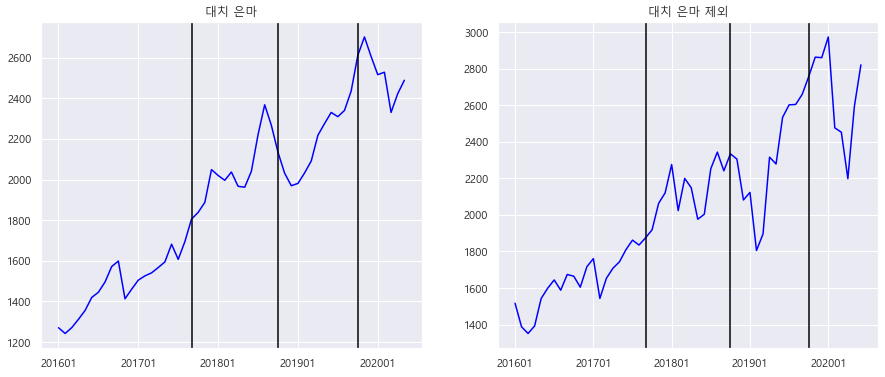

In [46]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
plt.plot(daechi[daechi.name == '은마'].groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')
plt.title('대치 은마')

plt.subplot(122)
plt.plot(daechi_not_eunma.groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('대치 은마 제외')
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')

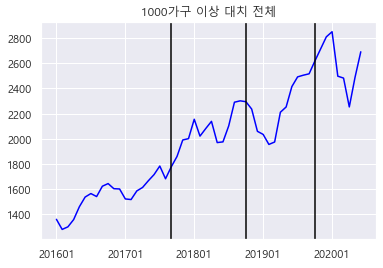

In [60]:
plt.plot(daechi_overall.groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('1000가구 이상 대치 전체')

plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')

추이로 보았을 때, 대치 전반의 1000가구 이상 아파트, 그리고 그 외의 소규모 아파트들이 모두 동일한 추이를 보이고 있다.
또한 전반적으로 투자 목적의 구입이 많기때문에, 이쪽은 데이터의 분산과 불안전성이 매우 클것으로 예상된다.

### 목동

In [61]:
yangcheon = seoul[seoul.only_gu == '양천구']
mokdong = yangcheon[yangcheon.dong == '목동']
mokdong.head()

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
88228,서울특별시 양천구 목동,555-4,555,4,CG아름채 목동아파트,39.201,201602,1,7,2016,목동중앙본로28길 10,27300,양천구,목동,696.410806,서울특별시 양천구 목동555-4
88229,서울특별시 양천구 목동,555-4,555,4,CG아름채 목동아파트,69.853,201602,3,2,2016,목동중앙본로28길 10,40500,양천구,목동,579.788985,서울특별시 양천구 목동555-4
88230,서울특별시 양천구 목동,555-4,555,4,CG아름채 목동아파트,49.589,201602,13,5,2016,목동중앙본로28길 10,34500,양천구,목동,695.718809,서울특별시 양천구 목동555-4
88231,서울특별시 양천구 목동,555-4,555,4,CG아름채 목동아파트,55.985,201604,3,7,2016,목동중앙본로28길 10,37400,양천구,목동,668.036081,서울특별시 양천구 목동555-4
88232,서울특별시 양천구 목동,555-4,555,4,CG아름채 목동아파트,46.797,201604,8,5,2016,목동중앙본로28길 10,29700,양천구,목동,634.656068,서울특별시 양천구 목동555-4


목동의 핵심 지역은 목동 학원가를 둘러싼 목동 신시가지 지역이다. 이쪽 지역을 중점적으로 파악해보자

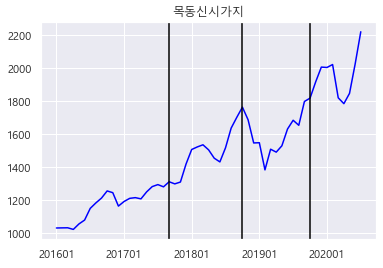

In [64]:
mokdong_over1000 = ['목동신시가지3', '목동신시가지6','목동센트럴아이파크위브(4단지)', '롯데캐슬위너', '목동신시가지5',\
                    '목동신시가지7', '목동청구한신아파트', '목동신시가지2', '목동신시가지1', '목동신시가지4']
mokdong_sinsigaji = mokdong[mokdong.name.map(lambda x: '목동신시가지' in x)]
plt.plot(mokdong_sinsigaji.groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('목동신시가지')
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')

여기서 역시 그 외 1000가구 이상의 아파트들을 추려보도록 하겠다.

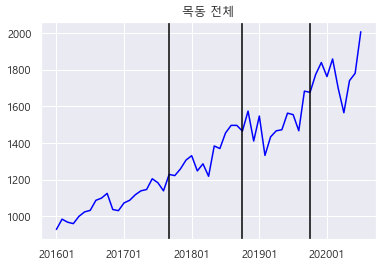

In [65]:
mokdong_overall = seoul[seoul.name.map(lambda x: x in mokdong_over1000)]

plt.plot(mokdong_overall.groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('목동 전체')
plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')

이번에는 신시가지를 제외한 지역을 파악해 보도록 하겠다.

In [67]:
mokdong_over1000_remove = [i for i in mokdong_over1000 if '신시가지' not in i]
print(mokdong_over1000_remove)
mokdong_not_sinsigaji = mokdong[mokdong.name.map(lambda x: x in mokdong_over1000_remove)]

['목동센트럴아이파크위브(4단지)', '롯데캐슬위너', '목동청구한신아파트']


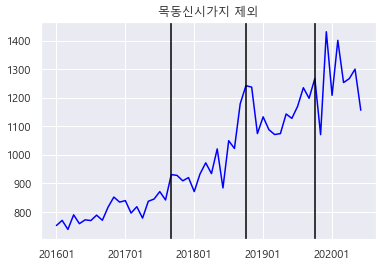

In [69]:
plt.plot(mokdong_not_sinsigaji.groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('목동신시가지 제외')

plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')

신시가지와 목동 전체의 경향성이 비슷하다. 등락의 폭은 대치에 비해 크지 않으나, 정책이 시행되면 평당 100~300 가량 떨어지고 회복을 하는 등 안정한 모습을 보이지는 않는다.

대치와 목동 두 지역이 이러한 경향성을 보이는 이유는 대치와 목동에 가장 큰 영향을 미쳐 유사한 경향성을 보이는 대치 은마와, 목동의 신시가지가 모두 
교육 목적으로 집값을 분석한다면 대치보다는 목동을 추천한다. 
하지만 두 지역 모두 변동이 심하고, 대치와 목동은 평당 가격이 평균 서울시 평당 가격에 비해 높기 때문에, 투기가 아닌 단순 교육 목적이라면 두 지역과 근접한 다른 지역의 집을 구매하여 거주하는 것이 합리적이다.

대치, 은마 주변의 1000세대 이상의 집을 분석하여 가격 추이를 분석해보았다. 그 중 우리가 원하는 가격대가 상대적으로 저렴하면서도 가격이 상대적으로 안정한 지역을 찾아보았다. 화곡동의 '우장산 아이파크, 이편한세상'이다.

### 목동 부가지역 - 화곡동

In [74]:
hwagok = seoul[seoul.dong == '화곡동']
hwagok.head()

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
20245,서울특별시 강서구 화곡동,46-220,46,220,(46-220),56.09,201610,13,5,2002,까치산로14길 26-13,19500,강서구,화곡동,347.655554,서울특별시 강서구 화곡동46-220
20246,서울특별시 강서구 화곡동,46-220,46,220,(46-220),58.09,201610,22,4,2002,까치산로14길 26-13,22000,강서구,화곡동,378.722672,서울특별시 강서구 화곡동46-220
20247,서울특별시 강서구 화곡동,46-410,46,410,(46-410),57.78,201603,7,5,2005,까치산로14길 26-8,17500,강서구,화곡동,302.872966,서울특별시 강서구 화곡동46-410
20248,서울특별시 강서구 화곡동,46-410,46,410,(46-410),59.06,201606,21,1,2005,까치산로14길 26-8,19700,강서구,화곡동,333.559092,서울특별시 강서구 화곡동46-410
20249,서울특별시 강서구 화곡동,918-25,918,25,AndPra레지던스,15.26,201601,3,15,2013,곰달래로 110-1,12800,강서구,화곡동,838.794233,서울특별시 강서구 화곡동918-25


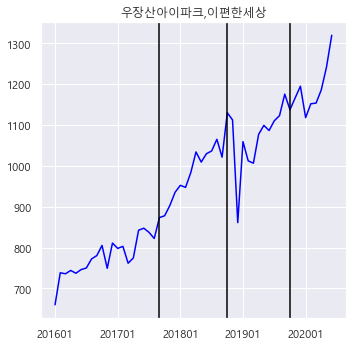

In [76]:
plt.figure(figsize = (12,12))
plt.subplot(221)
plt.plot(hwagok[hwagok.name == '우장산아이파크,이편한세상'].groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('우장산아이파크,이편한세상')

plt.axvline([20], color = 'black')
plt.axvline([33], color = 'black')
plt.axvline([45], color = 'black')

정책에 상관없이 대체로 안정한 경향성을 보인다. 하지만 2019년 1월에 가격이 급락하는 모습을 보이는데, 이를 위해서는 거래량과 그 때의 실거래값을 확인해야한다.

Text(0.5, 1.0, '우장산 아이파크, 이편한세상 월별 거래량')

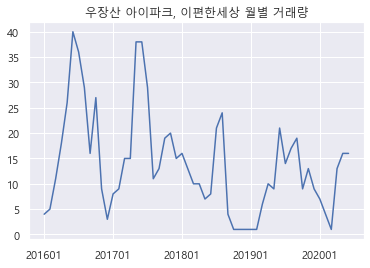

In [79]:
y = hwagok[hwagok.name == '우장산아이파크,이편한세상'].groupby(by = ['year_month'], as_index = False).count().price
plt.plot(y)
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('우장산 아이파크, 이편한세상 월별 거래량')

In [113]:
x = hwagok[hwagok.name == '우장산아이파크,이편한세상']
x2 = x.groupby('year_month').count().price.reset_index()
x2[x2.price < 5]

,year_month,price
0,201601,4
11,201612,3
32,201809,4
33,201811,1
34,201812,1
35,201901,1
36,201902,1
37,201903,1
49,202003,4
50,202004,1


In [81]:
x[x.year_month == 201901]

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
310013,서울특별시 강서구 화곡동,1159,1159,0,"우장산아이파크,이편한세상",114.98,201901,13,5,2008,강서로 266,99000,강서구,화곡동,861.019308,서울특별시 강서구 화곡동1159


2019년 01년 114.98m^2 크기의 9.9억 집 한채가 팔렸다. 이는 급매물 등의 outlier라도 보아도 무방할 듯 하다. (같은 크기의 아파트에 대하여 1달 전후로 가격이 유사하지만, 이 당시의 아파트만 8천만원가량 싸게 팔렸다.) 층수가 다르기 때문일까?

### 층수와 m2당 가격의 관계

Text(0.5, 1.0, '아파트 층별 m2 가격 분포')

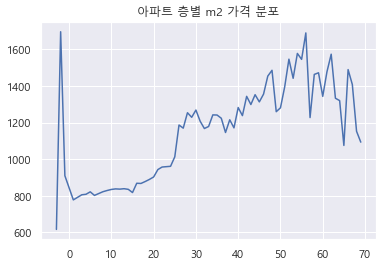

In [86]:
# 아파트별로, 층수별로, 평당가격 추이를 보기
floor = seoul.groupby('floor').mean().pyungdang
plt.plot(floor.index, floor)
plt.title('아파트 층별 m2 가격 분포')

Text(0.5, 1.0, '안정적이던 성북구 데이터만 층수별 파악')

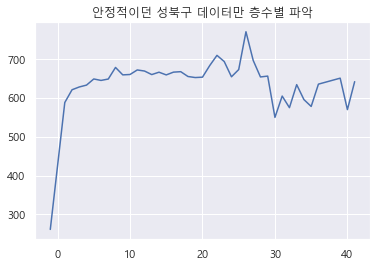

In [90]:
# 가격이 상대적으로 안정적이었던 성북구를 기준
seongbuk_floor = seoul[seoul.only_gu == '성북구'].groupby('floor').mean().pyungdang
plt.plot(seongbuk_floor.index, seongbuk_floor)
plt.title('안정적이던 성북구 데이터만 층수별 파악')

Text(0.5, 1.0, '강남3구 층별')

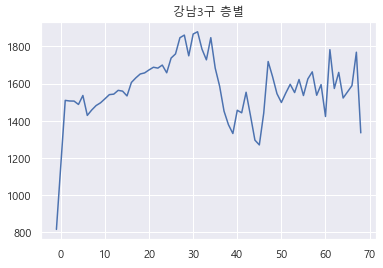

In [92]:
# 강남, 서초, 잠실만
gsj_list = ['강남구', '서초구']
gsj = seoul[(seoul.only_gu.map(lambda x: x in gsj_list)) | (seoul.dong == '잠실동')]
gsj_floor = gsj.groupby('floor').mean().pyungdang
plt.plot(gsj_floor.index, gsj_floor)
plt.title('강남3구 층별')

Text(0.5, 1.0, '마용성 층별 가격 분포')

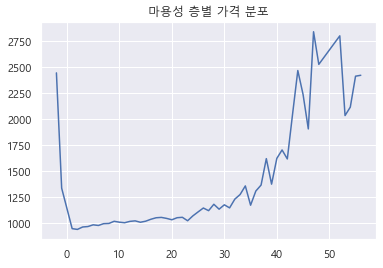

In [94]:
# 성동구, 마포구, 용산구

smy_list = ['성동구', '마포구', '용산구']
smy = seoul[(seoul.only_gu.map(lambda x: x in smy_list))]
smy_floor = smy.groupby('floor').mean().pyungdang
plt.plot(smy_floor.index, smy_floor)
plt.title('마용성 층별 가격 분포')

높은 층수의 경우 특수한 아파트가 많기 때문에 제외하고, 1층 이하의 아파트들 역시 특수한 아파트(한남 더힐)이기 때문에 압도적으로 높은 가격이 형성된다. 따라서 1층부터 10층까지는 유의미한 차이가 있다고 생각되지 않는다.  
  
우장산 아이파크와 이편한세상을 자세히 알아보자

Text(0.5, 1.0, '우장산 아이파크, e편한세상 층수별 가격분포')

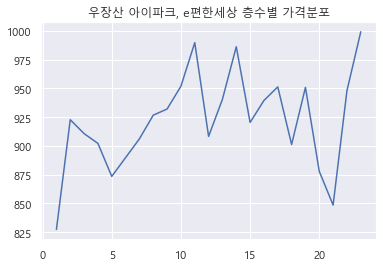

In [100]:
# 우장산 아이파크 이편한세상
hwagok_floor = hwagok[hwagok.name == '우장산아이파크,이편한세상'].groupby('floor').mean().pyungdang
plt.plot(hwagok_floor.index, hwagok_floor)
plt.title('우장산 아이파크, e편한세상 층수별 가격분포')

정확한 비교를 위해 이 당시의 층수에 따른 평당 가격을 비교해보자.

![201901%20%EC%9A%B0%EC%9E%A5%EC%82%B0%EC%95%84%EC%9D%B4%ED%8C%8C%ED%81%AC%EC%9D%B4%ED%8E%B8%ED%95%9C%EC%84%B8%EC%83%81.JPG](attachment:201901%20%EC%9A%B0%EC%9E%A5%EC%82%B0%EC%95%84%EC%9D%B4%ED%8C%8C%ED%81%AC%EC%9D%B4%ED%8E%B8%ED%95%9C%EC%84%B8%EC%83%81.JPG)

In [103]:
hwagok_yf = hwagok[hwagok.name == '우장산아이파크,이편한세상'].groupby(['year_month','floor']).pyungdang.mean().reset_index()
hwagok_yf

,year_month,floor,pyungdang
0,201601,9,694.362716
1,201601,10,652.287354
2,201601,14,654.205607
3,201601,18,639.241607
4,201602,8,741.438155
...,...,...,...
498,202007,12,1020.177422
499,202007,15,1363.947156
500,202007,16,1433.811270
501,202007,17,1500.500167


In [105]:
hwagok_around = hwagok_yf[hwagok_yf.year_month > 201803][hwagok_yf.year_month < 201909][hwagok_yf.floor>3][hwagok_yf.floor<10]
hwagok_around

,year_month,floor,pyungdang
310,201804,6,1197.065689
311,201804,7,982.699776
319,201805,5,976.926935
320,201805,9,1018.006355
325,201806,5,1128.709570
...,...,...,...
391,201907,6,1018.006355
392,201907,8,1143.038225
393,201907,9,1096.653391
402,201908,4,1242.080694


In [106]:
want = hwagok_around.groupby('year_month').mean().pyungdang
want

year_month
201804    1089.882732
201805     997.466645
201806    1038.998079
201807     992.012596
201808    1064.424316
201809    1018.006355
201811    1129.810521
201901     861.019308
201904    1167.055685
201905    1091.311452
201906    1142.871117
201907    1068.926082
201908    1147.696814
Name: pyungdang, dtype: float64

Text(0.5, 1.0, '목동 우장산 아이파크 이편한세상, 201803-201909, 3-10층 대한 m^2당 가격')

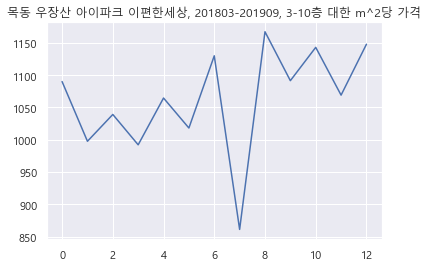

In [107]:
plt.plot(np.arange(len(want)), want)
plt.title("목동 우장산 아이파크 이편한세상, 201803-201909, 3-10층 대한 m^2당 가격")

우장산 아이파크는 시기별로 3층-10층 건물의 평당 가격 평균을 구했을 때, 201901에만 유독 값이 떨어졌음을 확인할 수 있다. 즉 층수별로도 생각해보았을 때 201901에 판매된 건물은 outlier라고 생각할 수 있다.

### 대치 대안지역 - 양재동

In [110]:
useong = seoul[seoul.dong == '양재동'][seoul.name == '우성']
useong.head()

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
70172,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201601,11,6,1991,바우뫼로 91,71000,서초구,양재동,839.441948,서울특별시 서초구 양재동154-2
70173,서울특별시 서초구 양재동,154-2,154,2,우성,73.15,201601,12,8,1991,바우뫼로 91,60000,서초구,양재동,820.232399,서울특별시 서초구 양재동154-2
70174,서울특별시 서초구 양재동,154-2,154,2,우성,73.15,201601,25,3,1991,바우뫼로 91,63000,서초구,양재동,861.244019,서울특별시 서초구 양재동154-2
70175,서울특별시 서초구 양재동,154-2,154,2,우성,84.88,201601,26,9,1991,바우뫼로 91,73000,서초구,양재동,860.037700,서울특별시 서초구 양재동154-2
70176,서울특별시 서초구 양재동,154-2,154,2,우성,73.15,201601,30,4,1991,바우뫼로 91,60000,서초구,양재동,820.232399,서울특별시 서초구 양재동154-2


Text(0.5, 1.0, '양재 우성아파트')

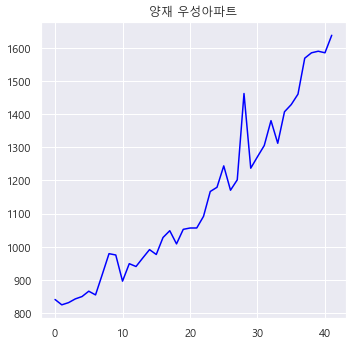

In [116]:
plt.figure(figsize = (12,12))
plt.subplot(221)
plt.plot(useong.groupby(by = ['year_month'], as_index = False).mean().pyungdang, color = 'blue')
plt.title('양재 우성아파트')

In [117]:
useong[useong.year_month == 201812]

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
266424,서울특별시 서초구 양재동,154-2,154,2,우성,73.15,201812,28,8,1991,바우뫼로 91,107000,서초구,양재동,1462.747779,서울특별시 서초구 양재동154-2


In [118]:
useong_around = useong[useong.year_month > 201801][useong.year_month < 201912][useong.floor>3][useong.floor<10]
useong_around

,sigungu,bunzi,bonbun,bubun,name,house_size,year_month,date,floor,built_date,road_address,price,only_gu,dong,pyungdang,seoul_full_address
266413,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201803,18,8,1991,바우뫼로 91,98200,서초구,양재동,1161.030977,서울특별시 서초구 양재동154-2
266414,서울특별시 서초구 양재동,154-2,154,2,우성,84.88,201803,20,8,1991,바우뫼로 91,99500,서초구,양재동,1172.243167,서울특별시 서초구 양재동154-2
266417,서울특별시 서초구 양재동,154-2,154,2,우성,73.15,201806,15,7,1991,바우뫼로 91,91000,서초구,양재동,1244.019139,서울특별시 서초구 양재동154-2
266418,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201807,12,7,1991,바우뫼로 91,99000,서초구,양재동,1170.489477,서울특별시 서초구 양재동154-2
266419,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201808,16,4,1991,바우뫼로 91,98500,서초구,양재동,1164.577914,서울특별시 서초구 양재동154-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343098,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201909,11,6,1991,바우뫼로 91,118000,서초구,양재동,1395.128872,서울특별시 서초구 양재동154-2
343099,서울특별시 서초구 양재동,154-2,154,2,우성,73.15,201909,23,8,1991,바우뫼로 91,105000,서초구,양재동,1435.406699,서울특별시 서초구 양재동154-2
343104,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201910,9,8,1991,바우뫼로 91,120000,서초구,양재동,1418.775124,서울특별시 서초구 양재동154-2
343107,서울특별시 서초구 양재동,154-2,154,2,우성,84.58,201910,19,5,1991,바우뫼로 91,125000,서초구,양재동,1477.890754,서울특별시 서초구 양재동154-2


In [119]:
want = useong_around.groupby('year_month').mean().pyungdang
want

year_month
201803    1166.637072
201806    1244.019139
201807    1170.489477
201808    1168.410541
201812    1462.747779
201901    1237.040528
201905    1284.253002
201907    1361.984746
201909    1415.267785
201910    1448.332939
201911    1460.885957
Name: pyungdang, dtype: float64

Text(0.5, 1.0, '양재 우성 201801-201912, 3-10층 대한 m^2당 가격')

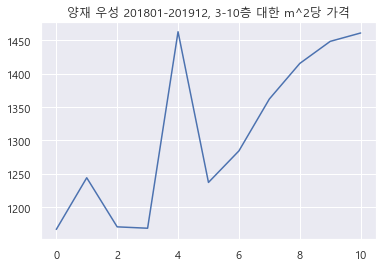

In [120]:
plt.plot(np.arange(11), want)
plt.title("양재 우성 201801-201912, 3-10층 대한 m^2당 가격")

이경우 역시 특수한 매물로 인한 Outlier일 가능성이 높다. 따라서 두 아파트였던  
1. 우장산 아이파크 & 이편한세상
2. 양재동 우성아파트  
는 각각 목동, 대치의 대안이 될 수 있다.

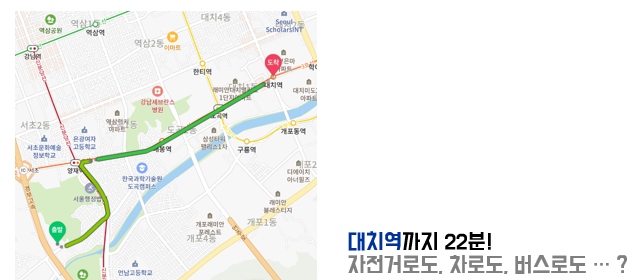

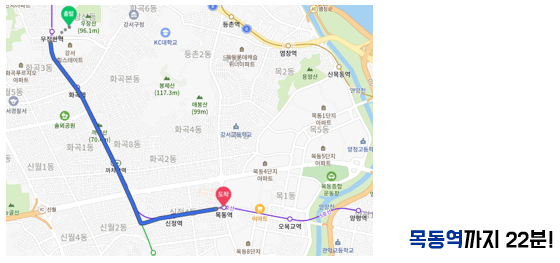

### 4.2) 안정적인 투자

추이가 비교적 안정적이고, 꾸준한 증가추세를 보이는 지역을 탐색해보던중, 성북구의 추이가 비교적 안정적임을 파악할 수 있었다.

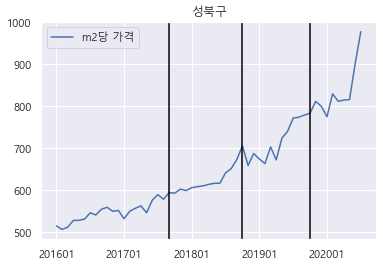

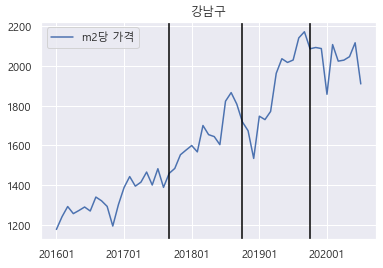

In [124]:
sungbook = seoul[seoul.only_gu == '성북구']
simple_plot(sungbook, '성북구')
simple_plot(gangnam, '강남구')

강남구와의 비교 결과, 분산이 확실히 작은것을 확인할 수 있다. 그중 유명한 길음 뉴타운을 확인해보자

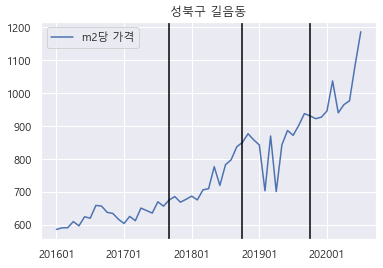

In [126]:
gilem = sungbook[sungbook.sigungu == '서울특별시 성북구 길음동']
simple_plot(gilem, '성북구 길음동')

해당 plot에서 붉은 지점을 체크해야한다.

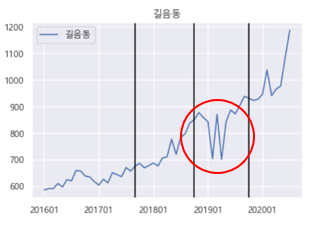

Text(0.5, 1.0, '길음동 거래량')

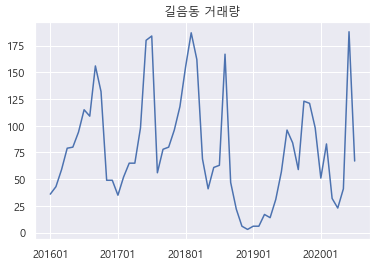

In [130]:
plt.plot(gilem.groupby(by = ['year_month'], as_index = False).count().pyungdang)
plt.xticks(np.arange(0,55, step = 12), [201601,201701,201801,201901, 202001])
plt.title('길음동 거래량')

길음동 19년도 1월의 경우 거래량이 급감한것을 확인할 수 있다. 따라서 저 데이터는 실제 추이가 급격히 변동했다고 평가하기 보다는 데이터 부족에 따른 왜곡으로 해석할 수 있는데, 저 기간의 해석만 가능하면 해결될 것으로 보인다.

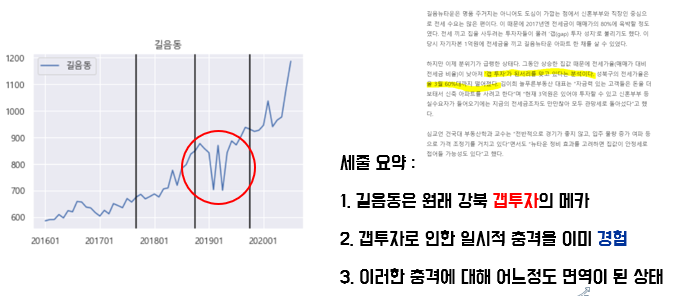

따라서 길음동은 현재 갭투자로부터 비교적 안전하고, 전체적으로 안정된 추이를 보인다. 길음동 내 길음뉴타운의 해당 아파트들을 구매하는 것이 바람직하다.

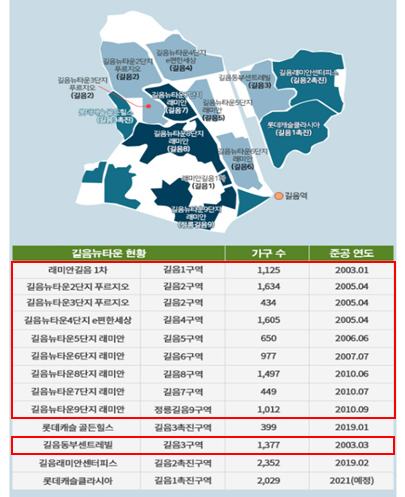